In [96]:
from lark import Lark
from lark.tree import pydot__tree_to_png
from yapf.yapflib.yapf_api import FormatCode 

import pydot
from IPython.display import Image, display
from IPython.core.display import HTML

import re

%matplotlib inline

### Описание грамматики

In [80]:
grammar = r"""  ?start: value
                ?value: dict
                      | if
                      | array
                      | STRING
                      | VARIABLE
                      | operator
                      | action_operator
                      | SIGNED_NUMBER      -> number
                      | "true"             -> true
                      | "false"            -> false
                      | "null"             -> null

                if: "если" condition "тогда:" result
                        |  "если" condition "тогда:" result "но" condition result
                        |  "если" [condition "тогда:" result ("в случае" condition ":" result)*]
                        |  "если" [condition "тогда:" result ("в случае" condition ":" result)*] "иначе:" else

                
                condition: VARIABLE action_operator (VARIABLE | SIGNED_NUMBER)
                result: STRING | if
                else: STRING

                array: "[" [value ("," value)*] "]"
                dict: "{" [pair ("," pair)*] "}"
                pair: STRING ":" value

                ?operator: OPERATOR
                OPERATOR: "+:"|":"

                ?action_operator: ACTION_OPERATOR
                ACTION_OPERATOR: "<"|">"|"="|"=="|">="|"<="|"!="|"in"

                COMMENT: /#[^\n]*/
                _NEWLINE: ( /\r?\n[\t ]*/ | COMMENT )+

                VARIABLE: /[a-zA-Zа-яА-Я0-9_.-]+/
                STRING: /[a-zA-Zа-яА-Я0-9_.-]+/

                %import common.ESCAPED_STRING
                %import common.SIGNED_NUMBER
                %import common.WS
                %ignore WS

                _DEDENT: "<DEDENT>"
                _INDENT: "<INDENT>" """

### Код запроса на DSL

In [81]:
text = """если возраст > 18 тогда:
              если зарплата > 500000 тогда:
                  switch_credit_type
              в случае зарплата < 50000:
                  если трудовой_стаж > 2 тогда:
                      success
                  иначе: get_more_info
              иначе: get_more_info
          иначе: fail"""

### Построение дерева, используя модуль `Lark`

In [82]:
json_parser = Lark(grammar, start='value')
tree = json_parser.parse(text)

In [83]:
def load_tree_image(tree, path):
    pydot__tree_to_png(tree, path)
    display(Image(path))

Просмотр дерева

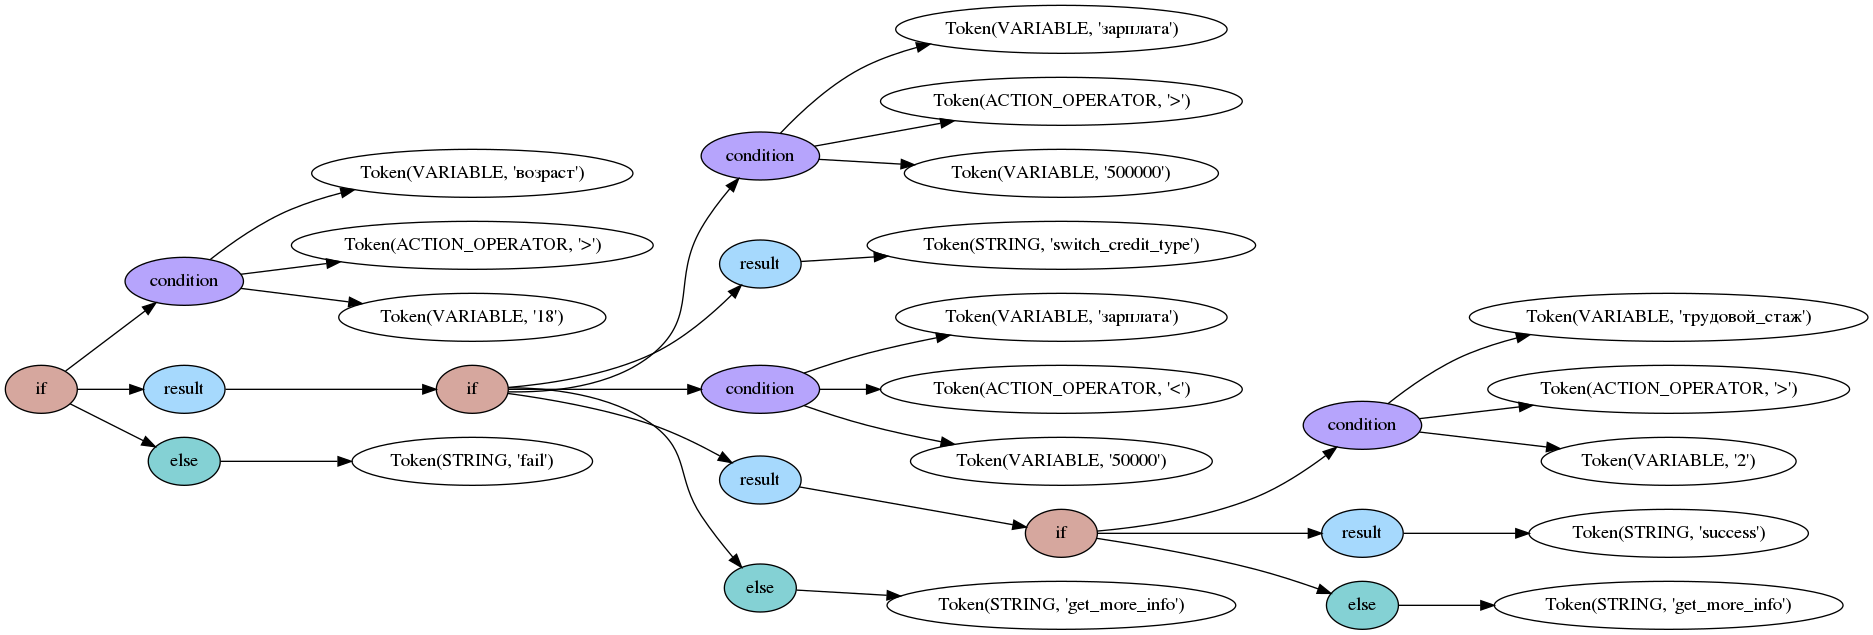

In [84]:
load_tree_image(tree, 'tree.png')

In [32]:
tree

Tree(if, [Tree(condition, [Token(VARIABLE, 'возраст'), Token(ACTION_OPERATOR, '>'), Token(SIGNED_NUMBER, '18')]), Tree(result, [Tree(if, [Tree(condition, [Token(VARIABLE, 'зарплата'), Token(ACTION_OPERATOR, '>'), Token(SIGNED_NUMBER, '500000')]), Tree(result, [Token(STRING, 'switch_credit_type')]), Tree(condition, [Token(VARIABLE, 'зарплата'), Token(ACTION_OPERATOR, '<'), Token(SIGNED_NUMBER, '50000')]), Tree(result, [Tree(if, [Tree(condition, [Token(VARIABLE, 'трудовой_стаж'), Token(ACTION_OPERATOR, '>'), Token(SIGNED_NUMBER, '2')]), Tree(result, [Token(STRING, 'success')]), Tree(condition, [Token(VARIABLE, 'трудовой_стаж'), Token(ACTION_OPERATOR, '<'), Token(SIGNED_NUMBER, '1')]), Tree(result, [Tree(if, [Tree(condition, [Token(VARIABLE, 'сумма_кредита'), Token(ACTION_OPERATOR, '>'), Token(VARIABLE, 'зарплата')]), Tree(result, [Token(STRING, 'refused')]), Tree(else, [Token(STRING, 'get_more_info')])])]), Tree(else, [Token(STRING, 'get_more_info')])])]), Tree(else, [Token(STRING, 'get_

### Обход дерева и генерация кода

In [85]:
code = []
add_indent = ''

def py_cond_gen(t, level=0):
    """ Обход дерева и добавление необходимых инструкций в list """
    global code, add_indent
    if t.data == 'if':
        code.append(add_indent + 'if')
        for i, child in enumerate(t.children):
            if child.data == 'condition':
                if 'if' not in code[-1]:
                    code.append(add_indent + 'elif')
                condition_expr = ' '.join([str(children) for children in child.children]) + ':\n'
                code.append(condition_expr)
            if child.data == 'result':
                if type(child.children[0]).__name__ == 'Tree' and child.children[0].data == 'if':
                    add_indent = '\t' * (level+1)
                    py_cond_gen(child.children[0], level=level+1)
                    add_indent = add_indent[:level]
                else:
                    code.append(add_indent + "\tprint('%s')" % child.children[0] + '\n')
            if child.data == 'else':
                code.append(add_indent + 'else:\n')
                code.append(add_indent + "\tprint('%s')" % child.children[0] + '\n')

py_cond_gen(tree)

In [86]:
for line in str(tree.pretty()).split('\n'):
    print(line)

if
  condition
    возраст
    >
    18
  result
    if
      condition
        зарплата
        >
        500000
      result	switch_credit_type
      condition
        зарплата
        <
        50000
      result
        if
          condition
            трудовой_стаж
            >
            2
          result	success
          else	get_more_info
      else	get_more_info
  else	fail



Замена символов в строке, не соответствующих синтаксису python

In [87]:
replace_dict = {'\n ': '\n', '\t ': '\t'}

In [88]:
def multiple_replace(text, adict):
    rx = re.compile('|'.join(map(re.escape, adict)))
    def one_xlat(match):
        return adict[match.group(0)]
    return rx.sub(one_xlat, text)

In [89]:
code_str = multiple_replace(' '.join(code), replace_dict)

In [90]:
code_str

"if возраст > 18:\n\tif зарплата > 500000:\n\t\tprint('switch_credit_type')\n\telif зарплата < 50000:\n\t\tif трудовой_стаж > 2:\n\t\t\tprint('success')\n\t\telse:\n\t\t\tprint('get_more_info')\n\telse:\n\t\tprint('get_more_info')\nelse:\n\tprint('fail')\n"

In [99]:
print(code_str)

if возраст > 18:
	if зарплата > 500000:
		print('switch_credit_type')
	elif зарплата < 50000:
		if трудовой_стаж > 2:
			print('success')
		else:
			print('get_more_info')
	else:
		print('get_more_info')
else:
	print('fail')



Исполнение сгенерированного кода с передаваемыми параметрами 

In [95]:
exec(code_str, {"возраст": 20, "зарплата": 110000, "трудовой_стаж": 6, "сумма_кредита": 40000})

get_more_info
